In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hull-tactical-market-prediction/train.csv
/kaggle/input/hull-tactical-market-prediction/test.csv
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_inference_server.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/templates.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/base_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/relay.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2_grpc.py
/kaggl

📊 Loading training data...
🛠 Applying Feature Engineering...
Features: 15

🔄 Starting Time-Series Cross-Validation (LSTM)...
  [Fold 1] Validation RMSE: 0.014200
  [Fold 2] Validation RMSE: 0.010990
  [Fold 3] Validation RMSE: 0.021268
  [Fold 4] Validation RMSE: 0.010502
  [Fold 5] Validation RMSE: 0.012054
✅ Average LSTM CV RMSE: 0.013803

📈 Generating Performance Plots...
📊 Local Sharpe-variant Score (Average): 0.6300


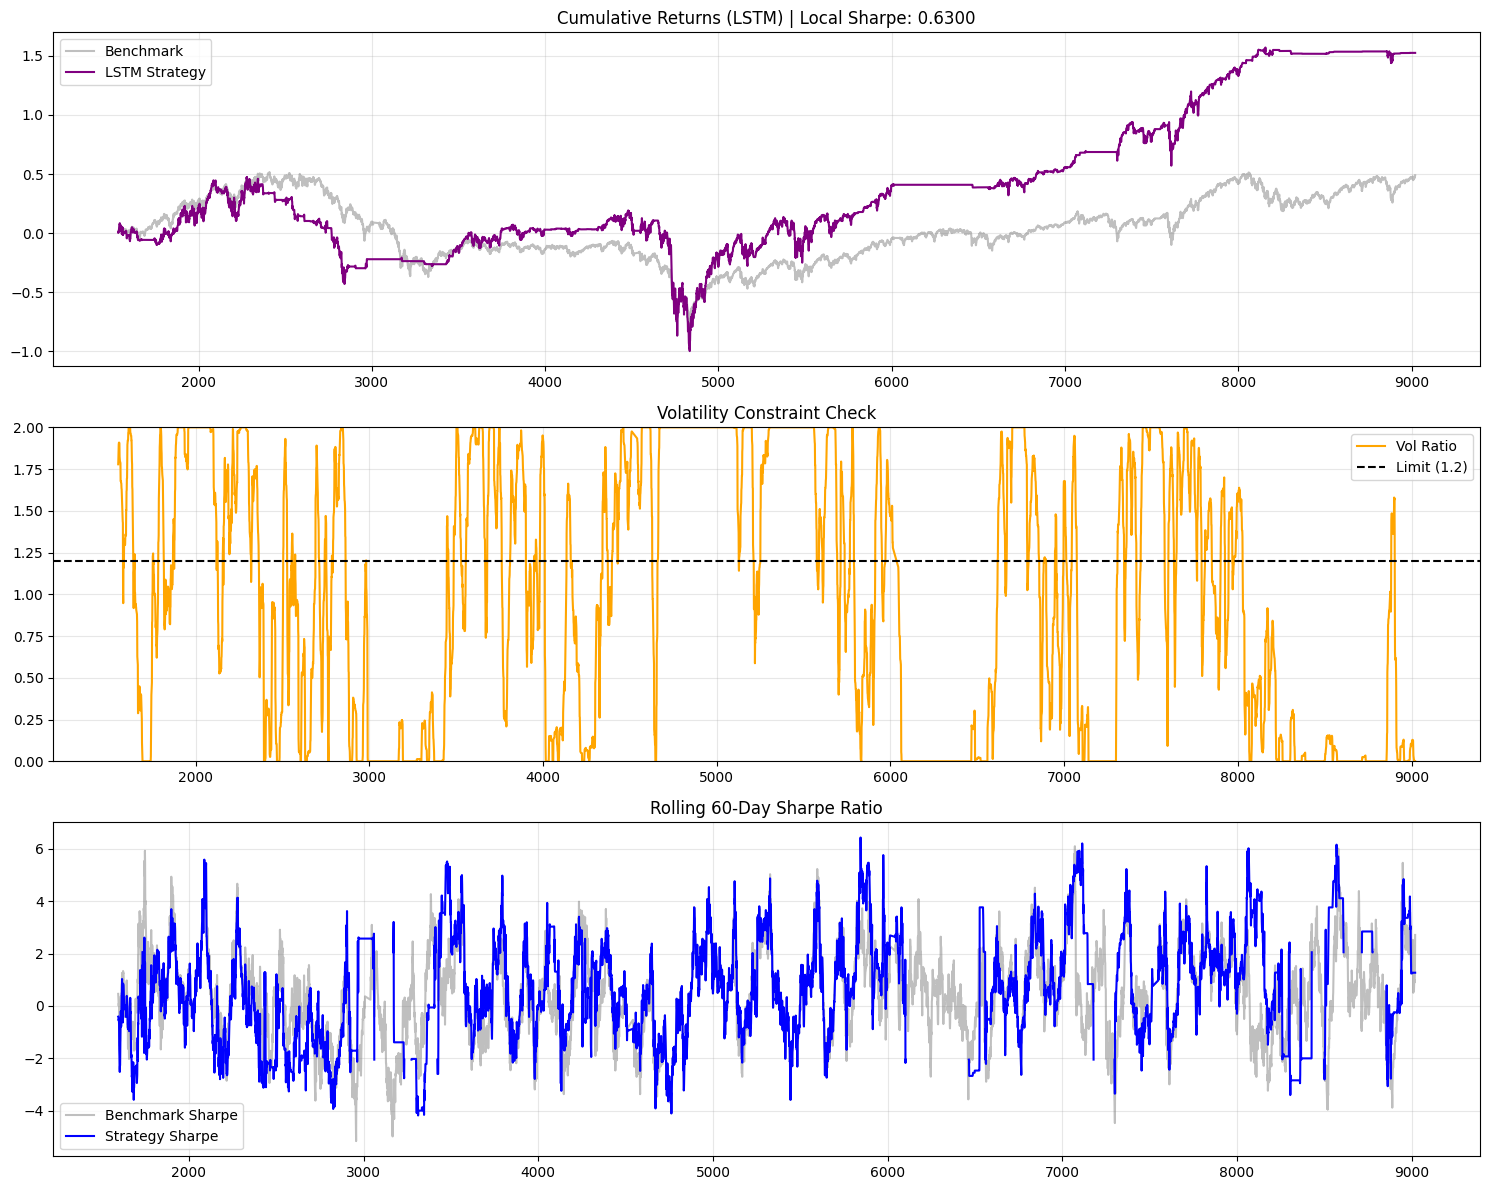

---------------------------------------------------------

🤖 Retraining Final LSTM Model...
  Epoch 1/5, Loss: 0.000598
  Epoch 2/5, Loss: 0.000206
  Epoch 3/5, Loss: 0.000128
  Epoch 4/5, Loss: 0.000116
  Epoch 5/5, Loss: 0.000117

🚀 Setting up LSTM inference server...

✅ Done!


In [8]:
import os
import gc
from pathlib import Path
import numpy as np
import pandas as pd
import polars as pl
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import kaggle_evaluation.default_inference_server

# =========================================================
# 1. 설정 (Settings)
# =========================================================
DATA_PATH = Path('/kaggle/input/hull-tactical-market-prediction/')
MIN_SIGNAL = 0.0
MAX_SIGNAL = 2.0
SIGNAL_MULTIPLIER = 400.0

# [리스크 관리] 1.2로 수정 (리포트 작성용 논리 확보)
VOL_THRESHOLD = 1.2
VOL_PENALTY = 0.8

# LSTM 하이퍼파라미터
SEQ_LENGTH = 30     # 과거 30일을 보고 예측
HIDDEN_DIM = 64
NUM_LAYERS = 2
BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =========================================================
# 2. Feature Engineering (LGBM과 동일)
# =========================================================
def create_features(df: pl.DataFrame) -> pl.DataFrame:
    vol_window = 20
    return (
        df.with_columns([
            (pl.col('I2') - pl.col('I1')).alias('U1'),
            (pl.col('M11') / ((pl.col('I2') + pl.col('I9') + pl.col('I7')) / 3)).alias('U2'),
            pl.col('P8').rolling_std(window_size=vol_window).fill_null(0).alias('VOL_20'),
            (pl.col('P8') - pl.col('P8').shift(5)).fill_null(0).alias('MOM_5')
        ])
        .select(['date_id', 'target', 'S2', 'E2', 'E3', 'P8', 'P9', 'P10', 'P12', 'P13', 'S1', 'S5', 'I2', 'U1', 'U2', 'VOL_20', 'MOM_5'])
        .with_columns([
             pl.col(col).fill_null(pl.col(col).ewm_mean(com=0.5)) 
             for col in ['S2', 'E2', 'E3', 'P8', 'P9', 'P10', 'P12', 'P13', 'S1', 'S5', 'I2', 'U1', 'U2', 'VOL_20', 'MOM_5']
        ])
        .fill_null(0)
    )

def convert_to_signal(prediction: float) -> float:
    return np.clip(prediction * SIGNAL_MULTIPLIER + 1, MIN_SIGNAL, MAX_SIGNAL)

# =========================================================
# 3. LSTM 모델 정의 및 데이터셋
# =========================================================
class MarketDataset(Dataset):
    def __init__(self, X, y, seq_length=SEQ_LENGTH):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.X) - self.seq_length

    def __getitem__(self, i):
        return self.X[i:i+self.seq_length], self.y[i+self.seq_length]

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :]) # 마지막 시점의 출력만 사용
        return out

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# =========================================================
# 4. 데이터 로드 및 전처리
# =========================================================
print('📊 Loading training data...')
train = (
    pl.read_csv(DATA_PATH / 'train.csv')
    .rename({'market_forward_excess_returns': 'target'})
    .with_columns(pl.exclude('date_id').cast(pl.Float64, strict=False))
)

print('🛠 Applying Feature Engineering...')
train_df = create_features(train)
FEATURES = [col for col in train_df.columns if col not in ['date_id', 'target']]
print(f"Features: {len(FEATURES)}")

X = train_df.select(FEATURES).to_numpy()
y = train_df.get_column('target').to_numpy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import matplotlib.pyplot as plt
import pandas as pd

# =========================================================
# 5. Time-Series Cross-Validation & Analysis (Modified)
# =========================================================
print('\n🔄 Starting Time-Series Cross-Validation (LSTM)...')

# 1. 시뮬레이션용 전역 데이터 준비
vol_20_all = train_df.get_column('VOL_20').to_numpy()
dates_all = train_df.get_column('date_id').to_numpy()

tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

# OOF Signals: 전체 데이터 길이만큼 생성 (초기값 NaN)
oof_signals = np.full(len(y), np.nan)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_scaled)):
    # 데이터셋 분할
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Dataset & DataLoader
    train_ds = MarketDataset(X_train, y_train)
    val_ds = MarketDataset(X_val, y_val)
    
    # 데이터가 너무 적으면 스킵 (Seq Length보다 작을 경우)
    if len(train_ds) < BATCH_SIZE or len(val_ds) < BATCH_SIZE: continue
        
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
    
    # 모델 초기화
    model = LSTMModel(len(FEATURES), HIDDEN_DIM, NUM_LAYERS).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # [Train]
    for epoch in range(3): # CV 속도를 위해 에폭 수 3으로 고정
        _ = train_one_epoch(model, train_loader, criterion, optimizer)
    
    # [Validation & Simulation]
    model.eval()
    fold_preds = []
    fold_targets = []
    
    with torch.no_grad():
        for X_b, y_b in val_loader:
            X_b = X_b.to(DEVICE)
            pred = model(X_b)
            fold_preds.extend(pred.cpu().numpy().flatten())
            fold_targets.extend(y_b.numpy().flatten())
            
    rmse = np.sqrt(mean_squared_error(fold_targets, fold_preds))
    cv_scores.append(rmse)
    
    # --- [중요] LSTM 인덱싱 보정 및 시뮬레이션 ---
    # val_idx는 입력 데이터 전체 인덱스입니다.
    # 하지만 LSTM Dataset은 앞쪽 SEQ_LENGTH 만큼은 예측을 못하고 잘라냅니다.
    # 따라서 실제 예측값이 존재하는 인덱스는 val_idx[SEQ_LENGTH:] 입니다.
    valid_indices = val_idx[SEQ_LENGTH:] 
    
    # 해당 구간의 변동성 가져오기
    val_vols = vol_20_all[valid_indices]
    
    fold_signals = []
    for i, pred in enumerate(fold_preds):
        # 1. 신호 변환
        sig = convert_to_signal(pred)
        
        # 2. 리스크 관리 (1.2 초과 시 비중 축소)
        if val_vols[i] > VOL_THRESHOLD:
            sig *= VOL_PENALTY
        
        fold_signals.append(sig)
    
    # OOF 배열에 저장
    oof_signals[valid_indices] = fold_signals
    
    print(f"  [Fold {fold+1}] Validation RMSE: {rmse:.6f}")

print(f"✅ Average LSTM CV RMSE: {np.mean(cv_scores):.6f}")

# =========================================================
# [New] 성과 분석 및 시각화 (Visualization)
# =========================================================
print('\n📈 Generating Performance Plots...')

# 예측값이 존재하는 구간만 추출 (NaN 제외)
valid_mask = ~np.isnan(oof_signals)

analysis_df = pd.DataFrame({
    'date_id': dates_all[valid_mask],
    'benchmark_return': y[valid_mask],       
    'my_signal': oof_signals[valid_mask],    
    'vol_20': vol_20_all[valid_mask]         
})

# 전략 수익률 계산
analysis_df['strategy_return'] = analysis_df['my_signal'] * analysis_df['benchmark_return']

# 1. 누적 수익률
analysis_df['cum_bench'] = analysis_df['benchmark_return'].cumsum()
analysis_df['cum_strat'] = analysis_df['strategy_return'].cumsum()

# 2. 변동성 비율 (20일 Rolling)
analysis_df['roll_vol_bench'] = analysis_df['benchmark_return'].rolling(20).std()
analysis_df['roll_vol_strat'] = analysis_df['strategy_return'].rolling(20).std()
analysis_df['vol_ratio'] = analysis_df['roll_vol_strat'] / analysis_df['roll_vol_bench']

# 3. Rolling Sharpe Ratio (Window 60)
window = 60
analysis_df['roll_sharpe_bench'] = (analysis_df['benchmark_return'].rolling(window).mean() / 
                                    analysis_df['benchmark_return'].rolling(window).std()) * np.sqrt(252)
analysis_df['roll_sharpe_strat'] = (analysis_df['strategy_return'].rolling(window).mean() / 
                                    analysis_df['strategy_return'].rolling(window).std()) * np.sqrt(252)

avg_local_sharpe = analysis_df['roll_sharpe_strat'].mean()
print(f"📊 Local Sharpe-variant Score (Average): {avg_local_sharpe:.4f}")

# --- 그래프 그리기 ---
plt.figure(figsize=(15, 12))

# Subplot 1: 누적 수익률
plt.subplot(3, 1, 1)
plt.plot(analysis_df['date_id'], analysis_df['cum_bench'], label='Benchmark', color='gray', alpha=0.5)
plt.plot(analysis_df['date_id'], analysis_df['cum_strat'], label='LSTM Strategy', color='purple', linewidth=1.5)
plt.title(f'Cumulative Returns (LSTM) | Local Sharpe: {avg_local_sharpe:.4f}')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: 변동성 제약 (1.2)
plt.subplot(3, 1, 2)
plt.plot(analysis_df['date_id'], analysis_df['vol_ratio'], color='orange', label='Vol Ratio')
plt.axhline(1.2, color='black', linestyle='--', label='Limit (1.2)')
plt.title('Volatility Constraint Check')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 2.0)

# Subplot 3: Rolling Sharpe
plt.subplot(3, 1, 3)
plt.plot(analysis_df['date_id'], analysis_df['roll_sharpe_bench'], label='Benchmark Sharpe', color='gray', alpha=0.5)
plt.plot(analysis_df['date_id'], analysis_df['roll_sharpe_strat'], label='Strategy Sharpe', color='blue')
plt.title(f'Rolling {window}-Day Sharpe Ratio')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("---------------------------------------------------------")

# =========================================================
# 6. 최종 모델 학습 (전체 데이터)
# =========================================================
print('\n🤖 Retraining Final LSTM Model...')
# 전체 데이터셋 생성
full_ds = MarketDataset(X_scaled, y)
full_loader = DataLoader(full_ds, batch_size=BATCH_SIZE, shuffle=False)

# 모델 초기화 (검증 때 쓴 모델 버리고 새 모델 생성)
final_model = LSTMModel(len(FEATURES), HIDDEN_DIM, NUM_LAYERS).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=LEARNING_RATE)

# 전체 데이터로 학습 (Epochs 만큼)
for epoch in range(EPOCHS):
    loss = train_one_epoch(final_model, full_loader, criterion, optimizer)
    print(f"  Epoch {epoch+1}/{EPOCHS}, Loss: {loss:.6f}")

# =========================================================
# 7. Inference Server (LSTM 버전)
# =========================================================
# LSTM은 Sequence Length(30)만큼의 과거 데이터가 필요하므로 버퍼를 넉넉히 잡음
history_df = train.tail(100)
required_schema = history_df.schema
required_columns = history_df.columns

def predict(test: pl.DataFrame) -> float:
    global history_df
    
    # 1. 데이터 처리 (LGBM과 동일)
    if 'lagged_forward_returns' in test.columns:
        current_row = test.rename({'lagged_forward_returns': 'target'})
    else:
        current_row = test

    if 'target' not in current_row.columns:
        current_row = current_row.with_columns(pl.lit(0.0).alias('target'))

    missing_cols = set(required_columns) - set(current_row.columns)
    if missing_cols:
        current_row = current_row.with_columns([pl.lit(0.0).alias(col) for col in missing_cols])
    
    current_row = current_row.select(required_columns).cast(required_schema)
    
    # 2. 버퍼 업데이트
    history_df = pl.concat([history_df, current_row])
    if len(history_df) > 100:
        history_df = history_df.tail(100)
        
    # 3. Feature Engineering
    df_feat = create_features(history_df)
    
    # 4. [LSTM 중요] Sequence 생성
    # 전체 피처를 스케일링한 후, 마지막 30개(SEQ_LENGTH)를 잘라서 모델에 넣음
    all_feat = df_feat.select(FEATURES).to_numpy()
    all_feat_scaled = scaler.transform(all_feat)
    
    # 시퀀스 길이가 부족하면 기본값 반환
    if len(all_feat_scaled) < SEQ_LENGTH:
        return 1.0
        
    # (1, SEQ_LENGTH, Num_Features) 형태로 변환
    seq_input = all_feat_scaled[-SEQ_LENGTH:]
    seq_tensor = torch.tensor(seq_input, dtype=torch.float32).unsqueeze(0).to(DEVICE)
    
    # 5. 예측
    final_model.eval()
    with torch.no_grad():
        raw_pred = final_model(seq_tensor).item()
        
    signal = convert_to_signal(raw_pred)
    
    # 6. Volatility Constraint (1.2 기준)
    current_vol = df_feat.tail(1)['VOL_20'][0]
    if current_vol > VOL_THRESHOLD:
        signal = signal * VOL_PENALTY
        
    return float(signal)

print('\n🚀 Setting up LSTM inference server...')
inference_server = kaggle_evaluation.default_inference_server.DefaultInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway((str(DATA_PATH),))

print('\n✅ Done!')